In [7]:
from anchor import utils
from anchor import anchor_tabular
import pandas as pd
import sklearn.ensemble
import numpy as np
from anchor import anchor_tabular
import os

In [8]:
dataset_folder = '../../../datasets/'
def filter_fn(data):
    to_remove = ['Does not meet the credit policy. Status:Charged Off',
        'Does not meet the credit policy. Status:Fully Paid',
        'In Grace Period', '-999', 'Current']
    for x in to_remove:
        data = data[data[:, 16] != x]
    return data
bad_statuses = set(["Late (16-30 days)", "Late (31-120 days)", "Default", "Charged Off"])
transformations = {
    16:  lambda x: np.array([y in bad_statuses for y in x]).astype(int),
    19:  lambda x: np.array([len(y) for y in x]).astype(int),
    6:  lambda x: np.array([y.strip('%') if y else -1 for y in x]).astype(float),
    35:  lambda x: np.array([y.strip('%') if y else -1 for y in x]).astype(float),
}
#features_to_use = [2, 12, 13, 19, 29, 35, 51, 52, 109]
features_to_use = [2, 12, 13, 19, 29] #, 35, 51, 52, 109]
categorical_features = [12] #, 109]
dataset = utils.load_csv_dataset(
    os.path.join(dataset_folder, 'lendingclub/LoanStats3a_securev1.csv'),
    16, ',',  features_to_use=features_to_use,
    feature_transformations=transformations, fill_na='-999',
    categorical_features=categorical_features, discretize=True,
    filter_fn=filter_fn, balance=True)
dataset.class_names = ['Good Loan', 'Bad Loan']
print(dataset.train[0])

[1. 0. 3. 0. 0.]


In [9]:
c = sklearn.ensemble.RandomForestClassifier(n_estimators=50, n_jobs=5)
c.fit(dataset.train, dataset.labels_train)
#print(np.unique(dataset.labels_train))
print('Train', sklearn.metrics.accuracy_score(dataset.labels_train, c.predict(dataset.train)))
print('Test', sklearn.metrics.accuracy_score(dataset.labels_test, c.predict(dataset.test)))

Train 0.6360529217199559
Test 0.5696649029982364


In [10]:
transformed_data = []

for r in dataset.train:
    transformed_data.append([dataset.categorical_names[i][int(r_)] for i, r_ in enumerate(r)])        

print(transformed_data[0])

train_data = pd.DataFrame(transformed_data, columns=dataset.feature_names)
print(train_data.shape)
nb_vals = 50

print(dataset.train[0])
print(dataset.train[0].reshape(1, -1))
y=[]
for k in range(0, nb_vals):
    y.append(c.predict(dataset.train[k].reshape(1, -1))[0])


['5400.00 < loan_amnt <= 10000.00', 'MORTGAGE', 'annual_inc > 82000.00', 'desc <= 4.00', 'inq_last_6mths <= 0.00']
(9070, 5)
[1. 0. 3. 0. 0.]
[[1. 0. 3. 0. 0.]]


In [11]:
import sys
sys.path.append(sys.path[0] + '/../..')

import arg_explainer as ae
from importlib import reload
reload(ae)
import arg_explainer as ae

print(dataset.feature_names)
explainer = ae.ArgTabularExplainer(c, train_data.iloc[0:nb_vals], y, 'lendingshort_' + str(nb_vals), compute=True, output_path='../../saves')

print(explainer.features_p_col)

['loan_amnt', 'home_ownership', 'annual_inc', 'desc', 'inq_last_6mths']
Generating arguments
len  1 : 0 ,  0
18 potential arg checked ( 0 not minimal)
len  2 : 11 ,  27
118 potential arg checked ( 0 not minimal)
len  3 : 42 ,  25
135 potential arg checked ( 135 not minimal)
len  4 : 2 ,  2
18 potential arg checked ( 178 not minimal)
len  5 : 0 ,  0
0 potential arg checked ( 46 not minimal)
Saving to  ../../saves\lendingshort_50_minimals.df
{'loan_amnt': {0, 1, 2, 3}, 'home_ownership': {4, 5, 6}, 'annual_inc': {8, 9, 10, 7}, 'desc': {11, 12, 13, 14}, 'inq_last_6mths': {16, 17, 15}}


In [12]:
G = explainer.build_attack_graph(compute=True, display_graph=False)
print('edges per node:', np.mean([len(G.edges(n)) for n in G.nodes()]))

explainer.export_graph('asp', '../../saves')
print(len(G.nodes()))

lendingshort_50
edges per node: 11.669724770642201
109


In [32]:
from typing import OrderedDict
import networkx as nx
from sklearn import preprocessing
import random
from numba import njit

le = preprocessing.LabelEncoder()


def generate_full_dataset():
    instance = OrderedDict.fromkeys(explainer.dataset.columns)
    full_dataset = []

    def gen_rec(instance, columns, col_index, full_dataset):
        inst_ = instance.copy()
        if col_index == len(columns) - 1:
            for f in explainer.features_p_col[columns[col_index]]:
                inst_[columns[col_index]] = explainer.feature_names[f][len(columns[col_index])+1:] #.strip(columns[col_index] + '_')
                full_dataset.append(list(inst_.values()))
        else:
            inst_ = instance.copy()
            for f in explainer.features_p_col[columns[col_index]]:
                inst_[columns[col_index]] = explainer.feature_names[f][len(columns[col_index])+1:] #.strip(columns[col_index] + '_')
                gen_rec(inst_, columns, col_index + 1, full_dataset)

    gen_rec(instance, list(instance.keys()), 0, full_dataset)
    return full_dataset

def instance2encoded(instance, dataset):
    encoded = []
    for col in dataset.categorical_features:
        encoded.append(dataset.categorical_names[col].index(instance[col]))
    return np.array(encoded)

def explore_full_dataset(nb_steps):
    full_dataset = generate_full_dataset()
    y_plus = [c.predict(instance2encoded(i_, dataset).reshape(1,-1))[0] for i_ in full_dataset]
    #train_data_plus = train_data = pd.DataFrame(transformed_data[:nb_vals] + transformed_data_plus, columns=dataset.feature_names)
    
    random.seed(1)
    indices = list(range(len(full_dataset)))
    random.shuffle(indices)
    full_dataset_shuff = [full_dataset[i] for i in indices] 
    y_plus_shuff = [y_plus[i] for i in indices]

    print(np.unique(np.array(y_plus_shuff)))
    
    step_len = len(full_dataset)//nb_steps
    steps = [i*step_len for i in range(1, nb_steps)]
    steps.append(len(full_dataset))
    for nb_vals in steps:
        dataset_t = full_dataset_shuff[:nb_vals]
        y_t = y_plus_shuff[:nb_vals]
        print('total length', len(dataset_t), len(y_t))
        train_data_plus = pd.DataFrame(dataset_t, columns=dataset.feature_names)

        explainer = ae.ArgTabularExplainer(c, train_data_plus, y_t, 'lendingshort_' + str(nb_vals) + '_synth', compute=True, output_path='../../saves')

        G = explainer.build_attack_graph(compute=True, display_graph=False)
        print('total args:', len(G.nodes()))
        print('edges per node:', np.mean([len(G.edges(n)) for n in G.nodes()]))

explore_full_dataset(16)

[0 1]
total length 432 432
Generating arguments
len  1 : 0 ,  0
25 potential arg checked ( 0 not minimal)
len  2 : 0 ,  0
267 potential arg checked ( 0 not minimal)
len  3 : 44 ,  32
1579 potential arg checked ( 0 not minimal)
len  4 : 925 ,  863
4470 potential arg checked ( 752 not minimal)
len  5 : 131 ,  196
1295 potential arg checked ( 5169 not minimal)
len  6 : 0 ,  0
93 potential arg checked ( 2711 not minimal)
len  7 : 0 ,  0
0 potential arg checked ( 432 not minimal)
Saving to  ../../saves\lendingshort_432_synth_minimals.df
lendingshort_432_synth
total args: 2191
edges per node: 67.92332268370608
total length 864 864
Generating arguments
len  1 : 0 ,  0
25 potential arg checked ( 0 not minimal)
len  2 : 0 ,  0
267 potential arg checked ( 0 not minimal)
len  3 : 3 ,  4
1579 potential arg checked ( 0 not minimal)
len  4 : 586 ,  546
5470 potential arg checked ( 90 not minimal)
len  5 : 858 ,  959
4543 potential arg checked ( 4898 not minimal)
len  6 : 10 ,  10
348 potential arg c

[5875, 10224, 0, 49592, 2178707, 37905, 1466414, 28295, 20643, 1020326, 15896, 698858, 12377, 9884, 494714, 7927, 74410, 6109, 358672, 4369, 266994, 2924, 1655, 198046, 720, 146475, 0, 106213, 73181, 59956, 46060, 25236]
(100, 432, 864, 1296, 1728, 2160, 2592, 3024, 3456, 3888, 4320, 4752, 5184, 5616, 6048, 6480, 6912, 13824, 20736, 27648, 34560, 41472, 48384, 55296, 62208, 69120, 76032, 82944, 89856, 96768, 103680, 110592) (321, 2191, 2976, 3543, 3800, 3885, 3938, 4039, 4105, 4069, 4076, 3950, 3811, 3656, 3545, 3423, 3328, 40873, 43517, 43637, 42544, 41781, 40581, 39143, 37655, 36079, 34368, 32532, 30397, 28463, 26542, 24909)


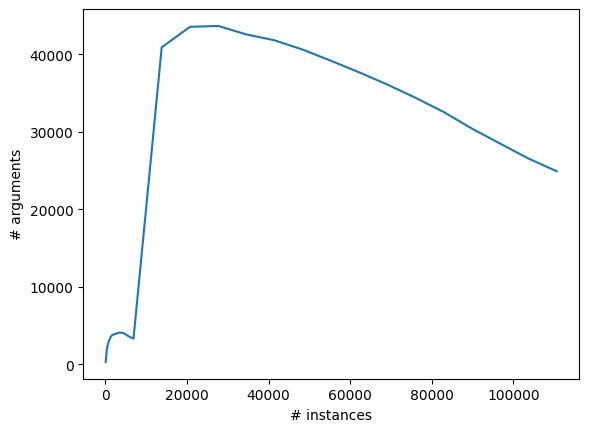

IndexError: list index out of range

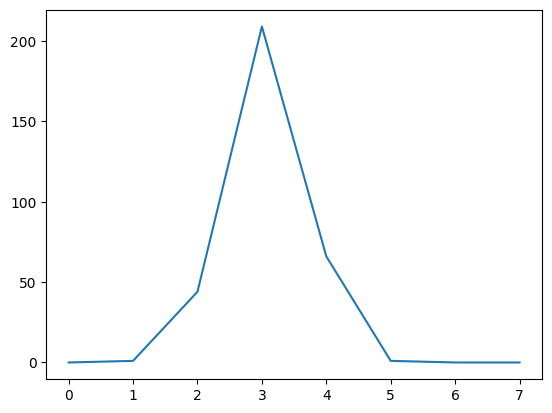

In [33]:
explainer.af_analysis(remove=["lending_"])

In [14]:
#ext_gen = explainer.extension_generator_from_graph()
ext_gen = explainer.extension_generator_from_sat(file='../../saves/lendingshort_50_sat.txt')
#max_covi_ext = explainer.make_selection('max_covi_incl', ext_gen)
max_covi_ext = explainer.make_selection('max_card', ext_gen)
res = explainer.apply_inference(max_covi_ext, 'universal')
#print(res)

explainer.display_explanations(verbose=True)

Using pre-processed file...
Reading ../../saves/lendingshort_50_sat_preprocessed.txt
Time for selection:  490.22679829597473
Len max_cov_exts:  1
id: 0 coverage: 10 Arg 1/3: frozenset({'inq_last_6mths_inq_last_6mths <= 0.00', 'annual_inc_annual_inc > 82000.00', 'home_ownership_MORTGAGE'})
id: 1 coverage: 0 Arg 1/0: None
id: 2 coverage: 0 Arg 1/0: None
id: 3 coverage: 0 Arg 1/0: None
id: 4 coverage: 0 Arg 1/0: None
id: 5 coverage: 0 Arg 1/0: None
id: 6 coverage: 0 Arg 1/0: None
id: 7 coverage: 9 Arg 1/5: frozenset({'inq_last_6mths_inq_last_6mths <= 0.00', 'desc_4.00 < desc <= 145.00', 'loan_amnt_loan_amnt > 15000.00'})
id: 8 coverage: 4 Arg 1/4: frozenset({'annual_inc_59000.00 < annual_inc <= 82000.00', 'desc_desc > 392.00'})
id: 9 coverage: 0 Arg 1/0: None
id: 10 coverage: 5 Arg 1/1: frozenset({'inq_last_6mths_0.00 < inq_last_6mths <= 1.00', 'desc_desc > 392.00'})
id: 11 coverage: 5 Arg 1/2: frozenset({'inq_last_6mths_0.00 < inq_last_6mths <= 1.00', 'desc_desc > 392.00'})
id: 12 covera